In [1]:
import sys
sys.path.append('/public/src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.linear_model import LinearRegression

from factor_evaluation_server import FactorEvaluation, DataService

In [2]:
# 初始化数据服务
ds = DataService()
df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 读取已有因子
factor_path = "/public/data/factor_data/ETH_15m_factor_data.txt"
factors = pd.read_csv(factor_path, sep='|')
original_columns = factors.columns.tolist()  # 保存原始列名

In [4]:
# 定义所有新因子计算函数
def calculate_filter_001_1(df):
    '''衡量当前波动率高低的过滤器'''
    log_ratio = np.log(df['close'] / df['close'].shift(1))
    hv = log_ratio.rolling(20).std()
    return hv

def calculate_filter_001_2(df):
    '''ATR过滤器'''
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(14).mean()
    return atr

def calculate_filter_001_3_keltner_channels(df, ema_period=20, atr_period=10, multiplier=2):
    '''凯尔特纳通道：基于ATR的波动通道'''
    ema = df['close'].ewm(span=ema_period, adjust=False).mean()
    
    # 计算ATR
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.ewm(span=atr_period, adjust=False).mean()
    
    # 计算通道宽度
    channel_width = multiplier * atr
    return (df['close'] - (ema - channel_width)) / (2 * channel_width)

def calculate_filter_002_1(df):
    '''衡量当前成交量高低的过滤器'''
    volume_mean = df['volume'].rolling(20).mean()
    volume_deviation = (df['volume'] - volume_mean) / volume_mean
    return volume_deviation

def calculate_filter_002_2_obv(df):
    '''能量潮指标：累积成交量平衡'''
    obv = (np.sign(df['close'].diff()) * df['volume'])
    obv = obv.cumsum()
    return obv

def calculate_filter_002_3_vwap(df):
    '''成交量加权平均价'''
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
    return vwap

def calculate_filter_003(df):
    '''衡量当前相对位置高低的过滤器'''
    up = df['high'].rolling(20).max()
    down = df['low'].rolling(20).min()
    price_position = (df['close'] - down) / (up - down)
    return price_position

def calculate_filter_004(df):
    '''衡量短期价格波动快慢的过滤器'''
    std_5 = df['close'].rolling(5).std()
    std_30 = df['close'].rolling(30).std()
    price_fluctuation = std_5 / std_30
    return price_fluctuation

def calculate_filter_005(df):
    '''
    衡量买卖压力的比例的过滤器
    '''
    imbalance = 2 * df['taker_buy_volume'] / df['volume'] - 1
    return imbalance

def calculate_filter_006(df):
    '''
    衡量平均交易量的过滤器
    '''
    average_trade_size = df['volume'] / df['trade_count']
    return average_trade_size

def calculate_filter_007(df):
    '''
    衡量 candle body 相对价格范围的大小的过滤器
    '''
    body = abs(df['close'] - df['open'])
    range_ = df['high'] - df['low']
    body_to_range_ratio = body / range_
    return body_to_range_ratio

def calculate_filter_008(df):
    '''衡量上影线相对价格范围的大小的过滤器'''
    upper_wick = df['high'] - df[['open', 'close']].max(axis=1)
    range_ = df['high'] - df['low']
    upper_wick_ratio = upper_wick / range_
    return upper_wick_ratio

def calculate_filter_009(df):
    '''衡量下影线相对价格范围的大小的过滤器'''
    lower_wick = df[['open', 'close']].min(axis=1) - df['low']
    range_ = df['high'] - df['low']
    lower_wick_ratio = lower_wick / range_
    return lower_wick_ratio

def calculate_filter_010_1(df, period=14):
    '''
    衡量RSI的过滤器
    '''
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace([np.inf, -np.inf], np.nan).fillna(0)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_filter_010_2_mfi(df, period=14):
    '''资金流量指数：结合价格和成交量的RSI变体'''
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    raw_money_flow = typical_price * df['volume']
    money_flow_direction = np.where(typical_price > typical_price.shift(1), 1, -1)
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    money_ratio = positive_flow.rolling(period).sum() / negative_flow.rolling(period).sum()
    money_ratio = money_ratio.replace([np.inf, -np.inf], np.nan).fillna(1)
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

def calculate_filter_011(df, short_period=12, long_period=26):
    '''
    衡量MACD的过滤器
    '''
    short_ema = df['close'].ewm(span=short_period, adjust=False).mean()
    long_ema = df['close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    return macd

def calculate_filter_012_aroon_up(df, period=14):
    '''阿隆上升指标：衡量价格创新高的能力'''
    high_idx = df['high'].rolling(period).apply(lambda x: x.argmax(), raw=True)
    aroon_up = 100 * (period - high_idx) / period
    return aroon_up

def calculate_filter_013_aroon_down(df, period=14):
    '''阿隆下降指标：衡量价格创新低的能力'''
    low_idx = df['low'].rolling(period).apply(lambda x: x.argmin(), raw=True)
    aroon_down = 100 * (period - low_idx) / period
    return aroon_down

def calculate_filter_014_aroon_oscillator(df, period=14):
    '''阿隆震荡器：衡量趋势强度'''
    aroon_up = calculate_filter_012_aroon_up(df, period)
    aroon_down = calculate_filter_013_aroon_down(df, period)
    return aroon_up - aroon_down

def calculate_filter_015_chaikin_money_flow(df, period=20):
    '''
    Chaikin资金流(CMF)
    '''
    money_flow_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    money_flow_multiplier = money_flow_multiplier.replace([np.inf, -np.inf], 0).fillna(0)
    money_flow_volume = money_flow_multiplier * df['volume']
    cmf = money_flow_volume.rolling(period).sum() / df['volume'].rolling(period).sum()
    return cmf

def calculate_filter_020_volume_price_trend(df):
    '''量价趋势指标：结合价格变动和成交量'''
    price_change = df['close'].pct_change()
    vpt = (price_change * df['volume']).cumsum()
    return vpt

def cmq_0702_factor(df):
    """
    改进点：
    1. 结合成交量分布和价格位置双重确认
    2. 增加交易意图分析（主动买入/卖出）
    3. 使用动态时间窗口
    """
    # 动态窗口：根据波动率调整回溯期
    volatility = df['close'].pct_change().rolling(96).std()
    
    # 处理NaN和inf问题 - 填充缺失值，避免除以零
    volatility = volatility.fillna(volatility.mean())  # 填充NaN为均值
    volatility = volatility.replace(0, 1e-6)           # 避免除以零
    volatility = np.clip(volatility, 1e-6, None)        # 确保最小正值
    
    # 计算窗口大小并确保为整数
    window_size = (960 / (volatility * 100 + 1))
    window_size = np.nan_to_num(window_size, nan=480)   # 替换NaN为默认值
    window_size = np.clip(window_size, 480, 1440).astype(int)
    
    # 预计算关键指标
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ret = (df['close'] - df['open']) / df['open']
    abs_ret = np.abs(ret)
    buy_power = df['taker_buy_volume'] / df['volume']
    
    # 核心指标：量价确认得分
    # 结合价格变动方向、主动买入比例和交易规模
    S = np.sign(ret) * abs_ret * buy_power * np.log1p(df['volume'])
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 找到有效的起始索引（确保有足够数据）
    start_idx = max(np.max(window_size), 96) + 1
    
    for i in range(start_idx, len(df)):
        w_size = window_size[i]
        start_idx = i - w_size
        end_idx = i - 1
        
        # 提取窗口数据
        window_avg_price = avg_price.iloc[start_idx:end_idx].values
        window_volume = df['volume'].iloc[start_idx:end_idx].values
        window_S = S.iloc[start_idx:end_idx].values
        
        # 按S值降序排序（聪明钱交易在前）
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 动态阈值（基于波动率）
        threshold_ratio = 0.3 - 0.15 * (volatility[i] / volatility.max())  # 波动大时降低阈值
        threshold = np.sum(window_volume) * threshold_ratio
        
        # 识别聪明钱交易
        cum_volume = np.cumsum(sorted_volume)
        smart_mask = cum_volume <= threshold
        
        if np.any(smart_mask):
            # 计算聪明钱VWAP（加权平均价）
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                              sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
            
            # 计算整体VWAP
            all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
            
            # 添加市场状态调整
            if all_vwap > window_avg_price[-96:].mean():  # 近期上涨
                factor_values[i] = smart_vwap / all_vwap
            else:  # 近期下跌
                factor_values[i] = 2 - (smart_vwap / all_vwap)  # 反转因子方向
    
    return pd.Series(-factor_values, index=df.index)

def zhongxin_0703_factor(df, window=20):
    """
    改进：引入分形市场理论，识别不同波动周期中的重心变化
    金融意义：捕捉市场结构变化，识别趋势转折点
    """
    df = df.copy()
    # 计算波动率分形维度
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 分形维度加权
        fractal_weights = group['fractal'].values
        
        # 上涨K线分形加权重心
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = fractal_weights[up_mask] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 下跌K线分形加权重心
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = fractal_weights[down_mask] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'avg_fractal': fractal_weights.mean()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 分形状态感知回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 分形状态作为交互项
        X = train_data[['G_u', 'avg_fractal']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u'], current['avg_fractal']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 分形波动调整
    fractal_level = daily_df['avg_fractal'].rolling(5).mean()
    daily_df['factor'] = daily_df['residual'] * fractal_level
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return (-df['factor_value']).clip(upper=12)

In [5]:
# 所有新因子计算函数的映射
factor_calculators = {
    'filter_001_1': calculate_filter_001_1,
    'filter_001_2': calculate_filter_001_2,
    'filter_001_3': lambda df: calculate_filter_001_3_keltner_channels(df),
    'filter_002_1': calculate_filter_002_1,
    'filter_002_2': calculate_filter_002_2_obv,
    'filter_002_3': calculate_filter_002_3_vwap,
    'filter_003': calculate_filter_003,
    'filter_004': calculate_filter_004,
    'filter_005': calculate_filter_005,
    'filter_006': calculate_filter_006,
    'filter_007': calculate_filter_007,
    'filter_008': calculate_filter_008,
    'filter_009': calculate_filter_009,
    'filter_010_1': lambda df: calculate_filter_010_1(df, 14),
    'filter_010_2': lambda df: calculate_filter_010_2_mfi(df, 14),
    'filter_011': lambda df: calculate_filter_011(df, 12, 26),
    'filter_012': lambda df: calculate_filter_012_aroon_up(df, 14),
    'filter_013': lambda df: calculate_filter_013_aroon_down(df, 14),
    'filter_014': lambda df: calculate_filter_014_aroon_oscillator(df, 14),
    'filter_015': lambda df: calculate_filter_015_chaikin_money_flow(df, 20),
    'filter_020': calculate_filter_020_volume_price_trend,
    '0702_聪明钱': cmq_0702_factor,
    '0703_时间重心偏离': zhongxin_0703_factor
}

In [6]:
# 只保留新因子与旧因子之间的相关性（排除新因子之间的相关性）
old_factors = original_columns  # 原始因子
new_to_old_corr = corr_matrix.loc[new_factors, old_factors]

# 识别高相关性因子（阈值=0.7）
threshold = 0.7
high_corr_records = []  # 用于存储高相关性记录

print(f"\n高相关性因子分析 (新因子与旧因子, |corr| > {threshold}):")
for new_factor in new_factors:
    # 只考虑与旧因子的相关性
    corr_series = new_to_old_corr.loc[new_factor]
    
    # 找出相关性绝对值超过阈值的因子
    high_corr = corr_series[abs(corr_series) > threshold]
    
    if not high_corr.empty:
        print(f"\n🔍 {new_factor} 与以下旧因子有高相关性:")
        for factor, corr_value in high_corr.items():
            # 判断相关性强弱和方向
            strength = "强" if abs(corr_value) > 0.8 else "中等"
            direction = "正" if corr_value > 0 else "负"
            
            print(f"  - {factor}: {corr_value:.4f} ({strength}{direction}相关)")
            high_corr_records.append({
                '新因子': new_factor,
                '旧因子': factor,
                '相关系数': corr_value,
                '相关强度': strength,
                '相关方向': direction
            })

NameError: name 'corr_matrix' is not defined

In [ ]:
# 直接显示高相关性因子表格
if high_corr_records:
    high_corr_df = pd.DataFrame(high_corr_records)
    
    # 美化显示表格
    print("\n📊 高相关性因子汇总表 (新因子 vs 旧因子):")
    display(high_corr_df[['新因子', '旧因子', '相关系数', '相关强度', '相关方向']]
            .sort_values(by='相关系数', key=abs, ascending=False)
            .style
            .background_gradient(cmap='coolwarm', subset=['相关系数'])
            .format({'相关系数': "{:.4f}"})
            .set_caption(f"高相关性因子汇总 (|corr| > {threshold})"))
else:
    print(f"\n✅ 未发现高相关性新因子与旧因子 (|corr| > {threshold})")


📊 高相关性因子汇总表 (新因子 vs 旧因子):


,新因子,旧因子,相关系数,相关强度,相关方向
9,filter_020,open_time,-0.8544,强,负
10,filter_020,close_time,-0.8544,强,负
0,filter_002_2,open_time,-0.8514,强,负
1,filter_002_2,close_time,-0.8514,强,负
4,filter_002_3,c_chu056,0.7313,中等,正
6,filter_002_3,high,-0.7285,中等,负
3,filter_002_3,c_chu023,-0.7284,中等,负
8,filter_002_3,close,-0.7283,中等,负
5,filter_002_3,open,-0.7283,中等,负
7,filter_002_3,low,-0.7282,中等,负


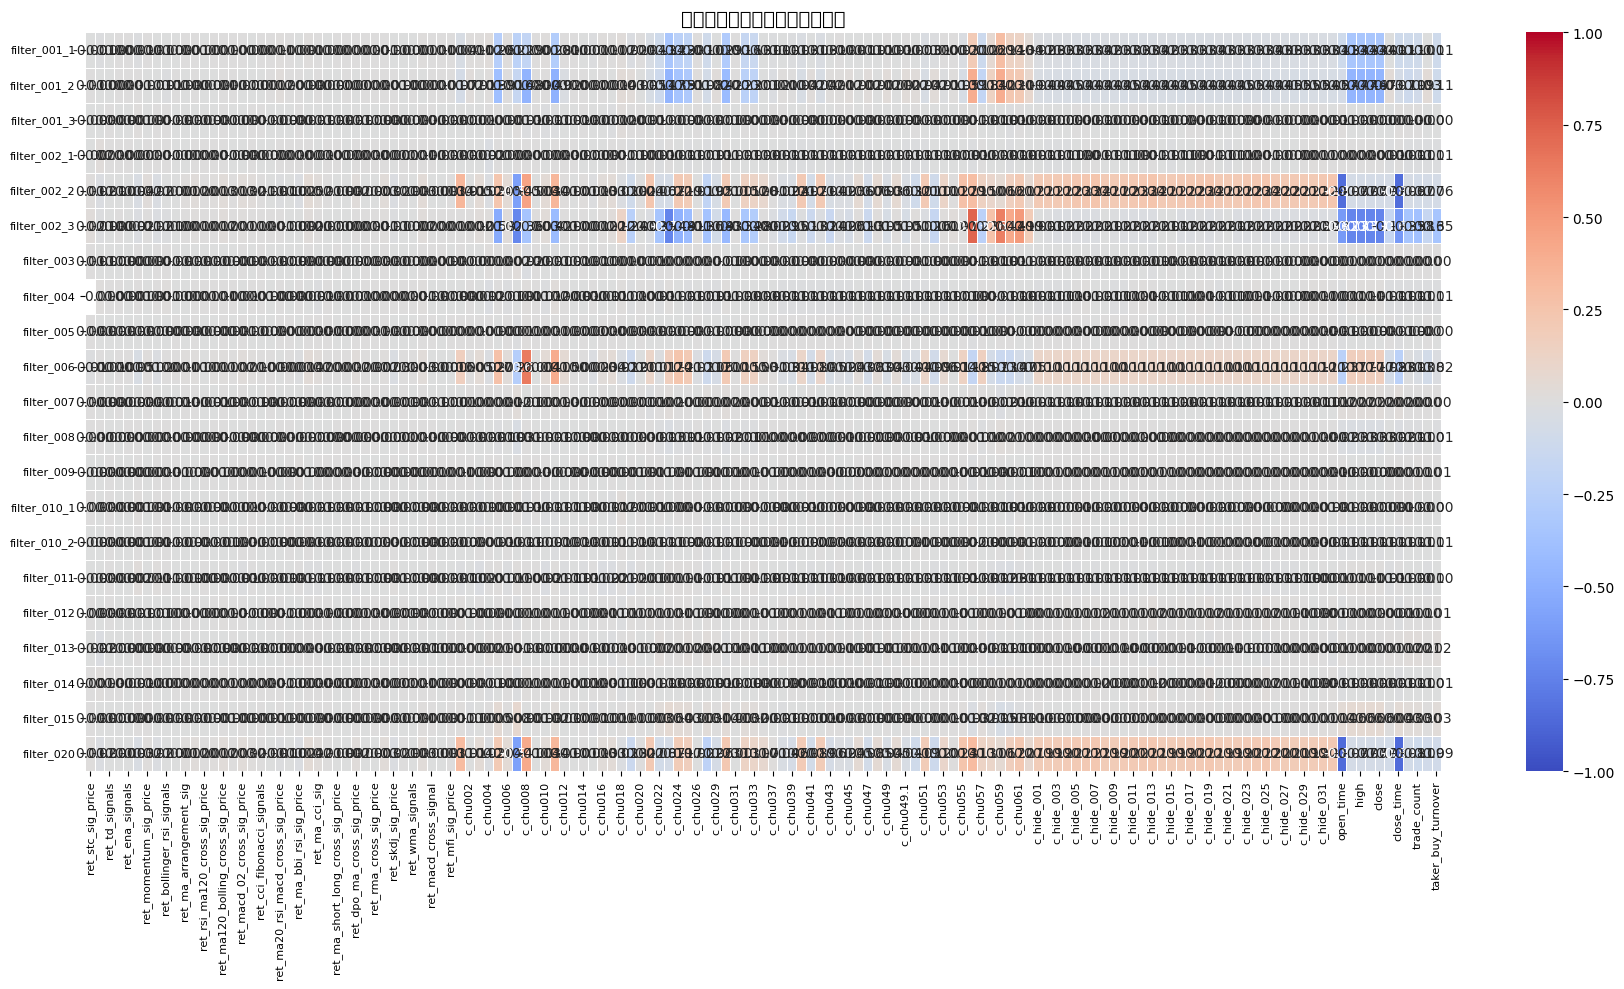


🎉 因子相关性分析完成!


In [ ]:
# 可视化：新因子与旧因子的相关性热力图
plt.figure(figsize=(18, 10))
heatmap = sns.heatmap(
    new_to_old_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('新因子与旧因子的相关性热力图', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 直接在Notebook中显示图表
plt.tight_layout()
plt.show()

print("\n🎉 因子相关性分析完成!")